# How to stream from the final node

A common use case is streaming from an agent is to stream LLM tokens from inside the final node. This guide demonstrates how you can do this.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


## Define model and tools

In [3]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import ToolNode


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]
model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
final_model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

model = model.bind_tools(tools)
# NOTE: this is where we're adding a tag that we'll be using later to filter the outputs of the final node
final_model = final_model.with_config(tags=["final_node"])

In [4]:
tool_node = ToolNode(tools=tools)

In [5]:
from typing import TypedDict, Annotated

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langchain_core.messages import BaseMessage

## Define graph

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage

In [7]:
def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "final"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def call_final_model(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    response = final_model.invoke([
        SystemMessage("Rewrite this in the voice of Al Roker"),
        HumanMessage(last_ai_message.content)
    ])
    # overwrite the last AI message from the agent
    response.id = last_ai_message.id
    return {"messages": [response]}

In [8]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
# add a separate final node
workflow.add_node("final", call_final_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')
workflow.add_edge("final", END)

In [9]:
app = workflow.compile()

In [10]:
from IPython.display import display, Image

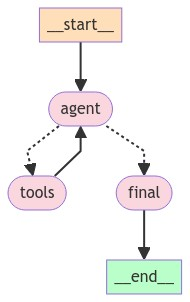

In [11]:
display(Image(app.get_graph().draw_mermaid_png()))

## Stream outputs from the final node

In [12]:
inputs = {"messages": [("human", "what's the weather in nyc?")]}
async for event in app.astream_events(inputs, version="v2"):
    kind = event["event"]
    tags = event.get("tags", [])
    if kind == "on_chat_model_stream" and "final_node" in tags:
        data = event["data"]
        if data["chunk"].content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(data["chunk"].content, end="|")

/Users/vadymbarda/.virtualenvs/langgraph/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Well| folks|,| looks| like| we|'ve| got| some| cloudy| skies| in| the| Big| Apple| today|.| So| grab| your| umbrella| just| in| case|,| and| don|'t| let| those| clouds| rain| on| your| parade|!|